# Compound Treats Disease Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

In [2]:
total_candidates_df = (
    pd
    .read_csv("../dataset_statistics/results/all_ctd_map.tsv.xz", sep="\t")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,doid_id,doid_name,resource,resource_id,drugbank_id,drug_name,disease,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
795720,DOID:1826,epilepsy syndrome,EFO,474,DB00313,Valproic Acid,epilepsy syndrome,pharmacotherapydb,1,9402,1,0.44093,9,1.0,1.0,0.0,686471,The rectal route of administration was effecti...,20,65851
828935,DOID:1826,epilepsy syndrome,EFO,474,DB01068,Clonazepam,epilepsy syndrome,pharmacotherapydb,1,937,1,0.61045,9,1.0,2.0,0.0,87832,Since the clinical data have been equivocal in...,40,65854


In [3]:
sentence_prediction_df = (
    pd
    .read_csv("results/all_predicted_ctd_sentences.tsv.xz", sep="\t")
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

,candidate_id,pred
650175,65851,0.963179
562154,65854,0.492458


In [4]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "doid_id", "doid_name", 
    "drugbank_id", "drug_name", 
    "text", "hetionet",
    "candidate_id", "split"
    ]]
    .merge(sentence_prediction_df, on="candidate_id")
)

total_candidates_pred_df.to_csv(
    "results/combined_predicted_ctd_sentences.tsv.xz", 
    sep="\t", index=False, compression="xz"
)

total_candidates_pred_df.head(2)

,doid_id,doid_name,drugbank_id,drug_name,text,hetionet,candidate_id,split,pred
0,DOID:1826,epilepsy syndrome,DB00313,Valproic Acid,The rectal route of administration was effecti...,1,65851,9,0.963179
1,DOID:1826,epilepsy syndrome,DB01068,Clonazepam,Since the clinical data have been equivocal in...,1,65854,9,0.492458


In [5]:
# DataFrame that groups disease and compound mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .groupby(["doid_id", "drugbank_id"], as_index=False)
    .agg({
        "pred": ['max', 'mean', 'median'], 
        'hetionet': 'max',
        "drug_name": 'first',
        "doid_name": 'first',
        "split": 'first'
    })
)
grouped_candidates_pred_df.head(2)

doid_id drugbank_id      pred                     hetionet  \
                                  max      mean    median      max   
0  DOID:0050156     DB00104  0.691620  0.691620  0.691620        0   
1  DOID:0050156     DB00129  0.310866  0.259353  0.235935        0   

     drug_name                      doid_name split  
         first                          first first  
0   Octreotide  idiopathic pulmonary fibrosis     9  
1  L-Ornithine  idiopathic pulmonary fibrosis     9

In [6]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'drug_name', 'doid_name', 'split'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]

grouped_candidates_pred_df.head(2)

,doid_id,drugbank_id,pred_max,pred_mean,pred_median,hetionet,drug_name,doid_name,split
0,DOID:0050156,DB00104,0.691620,0.691620,0.691620,0,Octreotide,idiopathic pulmonary fibrosis,9
1,DOID:0050156,DB00129,0.310866,0.259353,0.235935,0,L-Ornithine,idiopathic pulmonary fibrosis,9


In [7]:
grouped_candidates_pred_df = (
    grouped_candidates_pred_df
    .query("split==11")
    .drop("split", axis=1)
)
grouped_candidates_pred_df.head(2)

,doid_id,drugbank_id,pred_max,pred_mean,pred_median,hetionet,drug_name,doid_name
56,DOID:0050156,DB01708,0.303522,0.247713,0.247492,0,Dehydroepiandrosterone,idiopathic pulmonary fibrosis
149,DOID:0050741,DB00145,0.641047,0.641047,0.641047,0,Glycine,alcohol dependence


In [8]:
grouped_candidates_pred_df.hetionet.value_counts()

0    440
1      7
Name: hetionet, dtype: int64

In [9]:
performance_map = {}

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [12]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

# Hetionet Reconstruction

How well does sentence marginals reconstruct Hetionet?

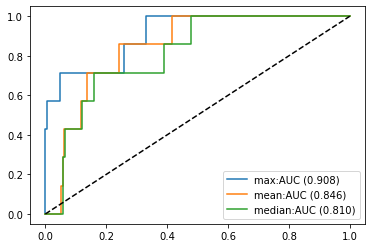

In [13]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

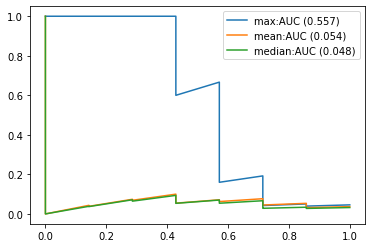

In [15]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimial Cutoff Using PR-Curve

In [16]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
152,1.0,0.142857,0.985271
151,1.0,0.285714,0.983058


In [17]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in precision_thresholds:

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_df
        .query("pred_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

,edges,in_hetionet,precision,sen_cutoff
0,3,Existing,1.00,0.982641
1,3,Existing,0.75,0.981844
2,1,Novel,0.75,0.981844
3,3,Existing,0.67,0.981844
4,1,Novel,0.67,0.981844
5,4,Existing,0.60,0.976413
6,2,Novel,0.60,0.976413
7,4,Existing,0.57,0.975945
8,3,Novel,0.57,0.975945
9,4,Existing,0.50,0.974425


[None]

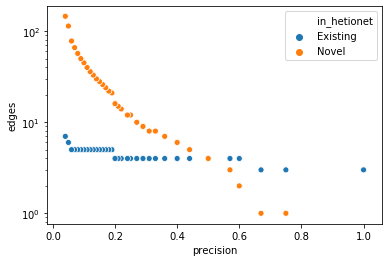

In [18]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df)
ax.set(yscale="log")

In [19]:
edges_added_df.to_csv("results/precision_ctd_edges_added.tsv", index=False, sep="\t")

# Optimal Cutoff using ROC Curve

In [14]:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = pd.np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
roc_optimal = Find_Optimal_Cutoff(grouped_candidates_pred_df.hetionet.values, grouped_candidates_pred_df.pred_max)[0]
roc_optimal

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.8435111999999999

In [20]:
(
    grouped_candidates_pred_df
    .query("pred_max > @roc_optimal")
    .sort_values("hetionet")
    .hetionet.value_counts()
)

0    112
1      5
Name: hetionet, dtype: int64

In [21]:
(
    grouped_candidates_pred_df
    .query("pred_max > @roc_optimal")
    .sort_values(["hetionet", "pred_max"], ascending=[True, False])
)

,doid_id,drugbank_id,pred_max,pred_mean,pred_median,hetionet,drug_name,doid_name
18905,DOID:7148,DB00554,0.981844,0.636101,0.618316,0,Piroxicam,rheumatoid arthritis
7164,DOID:1595,DB00234,0.981299,0.608923,0.624669,0,Reboxetine,endogenous depression
1993,DOID:10763,DB00374,0.975945,0.612945,0.605252,0,Treprostinil,hypertension
20366,DOID:8893,DB01132,0.974425,0.791113,0.865564,0,Pioglitazone,psoriasis
9598,DOID:1826,DB01181,0.969072,0.495508,0.454008,0,Ifosfamide,epilepsy syndrome
8038,DOID:1612,DB01151,0.969068,0.571943,0.511086,0,Desipramine,breast cancer
15267,DOID:3310,DB00163,0.967730,0.414225,0.352509,0,Vitamin E,atopic dermatitis
2166,DOID:10763,DB00859,0.966091,0.534917,0.524806,0,Penicillamine,hypertension
18758,DOID:7147,DB00586,0.963323,0.647096,0.648452,0,Diclofenac,ankylosing spondylitis
6604,DOID:14330,DB00268,0.962860,0.502614,0.479738,0,Ropinirole,Parkinson's disease
